Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Annotation counts for image 0006ff2aa7cd: {'blood_vessel': 0, 'glomerulus': 1, 'unsure': 0}


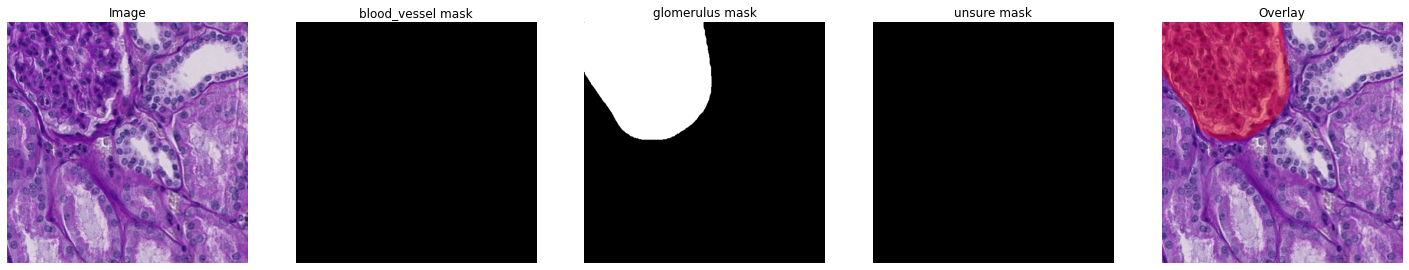

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Annotation counts for image 00168d1b7522: {'blood_vessel': 0, 'glomerulus': 1, 'unsure': 0}


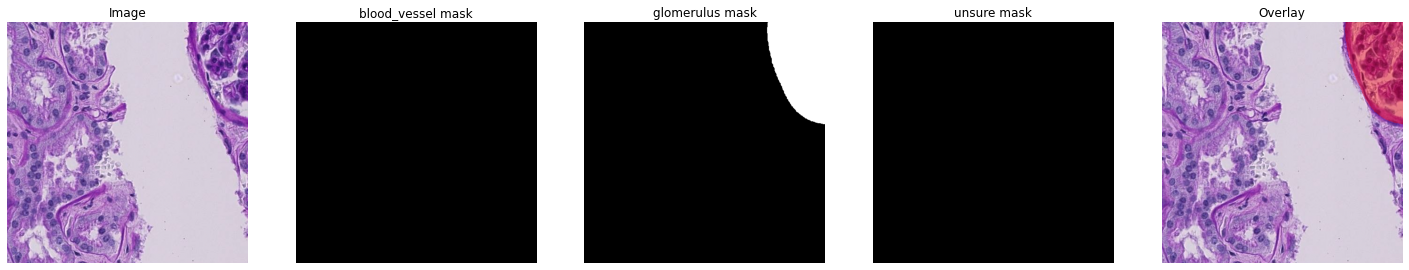

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Annotation counts for image 0033bbc76b6b: {'blood_vessel': 1, 'glomerulus': 0, 'unsure': 0}


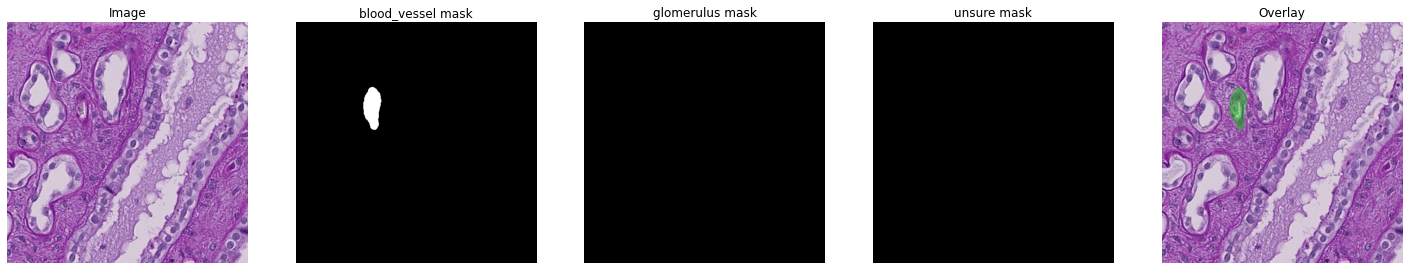

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Annotation counts for image 003504460b3a: {'blood_vessel': 1, 'glomerulus': 0, 'unsure': 0}


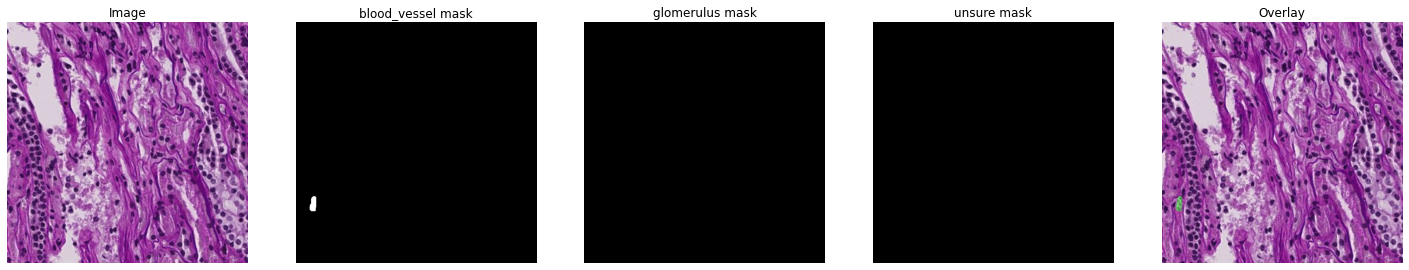

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Annotation counts for image 004daf1cbe75: {'blood_vessel': 1, 'glomerulus': 0, 'unsure': 0}


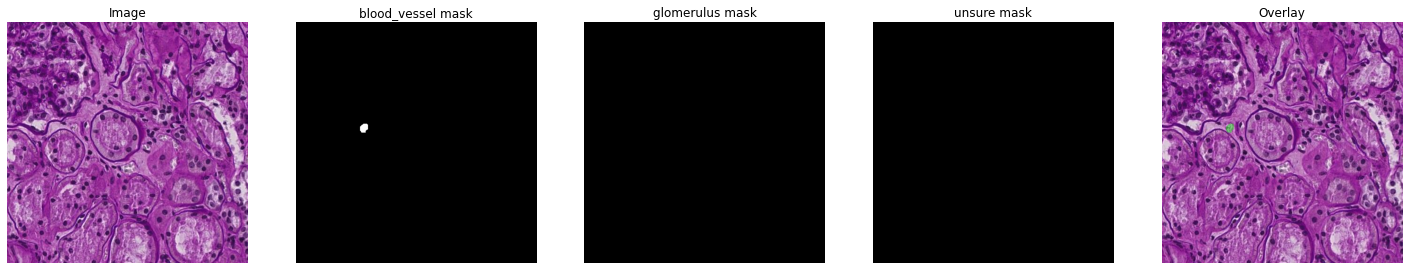

In [2]:
import glob
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cv2
from scipy.ndimage import label

train = glob.glob("/home/yiw/kg/input/train/*")
test = glob.glob("/home/yiw/kg/input/test/*")

annotations = {}

# Open the annotations file
with open('/home/yiw/kg/input/polygons.jsonl', 'r') as f:
    for line in f:
        annotation = json.loads(line)
        image_id = annotation['id']
        image_annotations = annotation['annotations']

        annotations[image_id] = image_annotations

image_map = {impath.split('/')[-1].split('.')[0]: impath for impath in train}
image_map.update({impath.split('/')[-1].split('.')[0]: impath for impath in test})
#print(len(set(image_map.keys())), len(set(annotations.keys())))
#7034 1633

def preprocess_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (512 , 512))
    return image_resized

preprocessed_images = {}
for i, image_id in enumerate(list(annotations.keys())):
    if image_id in image_map:
        image = cv2.imread(image_map[image_id])
        preprocessed_image = preprocess_image(image.copy())
        preprocessed_image_normalized = preprocessed_image / 255.0
        preprocessed_images[image_id] = preprocessed_image_normalized

def display_images_masks_overlays(image, masks, image_id):
    overlay = image.copy()
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255)]  # colors for blood vessels, glomerulus and unsure respectively

    # Initialize dictionary to hold annotation counts
    annotation_counts = {}
    
    for idx, (annotation_type, mask) in enumerate(masks[image_id].items(), 2):
        # Count the number of distinct areas in the mask
        labeled, num_areas = label(mask)
        annotation_counts[annotation_type] = num_areas

        # update overlay
        overlay[mask > 0] = colors[idx-2]

    # print annotation counts
    print(f"Annotation counts for image {image_id}: {annotation_counts}")

    # prepare for subplot
    plt.figure(figsize=(25,5))

    # plot the original image
    plt.subplot(1,5,1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')
    
    for idx, (annotation_type, mask) in enumerate(masks[image_id].items(), 2):
        # plot the binary masks
        plt.subplot(1,5,idx)
        plt.imshow(mask, cmap='gray')
        plt.title(f'{annotation_type} mask')
        plt.axis('off')

    # plot the overlay
    plt.subplot(1,5,5)
    plt.imshow(image)  # Use RGB image
    plt.imshow(overlay, alpha=0.4)  # change alpha to adjust transparency
    plt.title('Overlay')
    plt.axis('off')
    plt.show()

masks = {}
annotation_types = ['blood_vessel', 'glomerulus', 'unsure']
for image_id in annotations.keys():
    if image_id in preprocessed_images:
        polygons = annotations[image_id]
        # Load the preprocessed image
        image = preprocessed_images[image_id]

        # Create an empty mask of the same size as the image
        masks[image_id] = {annotation_type: np.zeros(image.shape[:2], dtype=np.uint8) for annotation_type in annotation_types}

        # For each polygon
        for polygon in polygons:
            annotation_type = polygon['type']
            lines = np.array(polygon['coordinates'])
            lines = lines.reshape(-1, 1, 2)
            # Draw the polygon on the mask
            cv2.fillPoly(masks[image_id][annotation_type], [lines], 255)
            break

        # Display the image and its masks if it's one of the first 5 images
        if len(masks) <= 5:
            display_images_masks_overlays(image, masks, image_id)

In [6]:
from tqdm import tqdm
from tqdm.notebook import tqdm
import json, itertools

idx = 0

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

def coco_structure(annotations):
    global idx
    #annotation_types = ['blood_vessel', 'glomerulus', 'unsure']
    #cat_ids = {annotation_type: idx+1 for idx, annotation_type in enumerate(annotation_types)}
    #cats =[{'name':name, 'id':id} for name, id in cat_ids.items()]
    cats =[{'name': "blood_vessel", 'id':1}]
    images = [{'id':image_id, 'width': 512, 'height': 512, 'file_name': image_map[image_id]} for image_id in annotations.keys()]
    coco_annotations = []

    for _, image_id in enumerate(tqdm(list(annotations.keys()))):
        polygons = annotations[image_id]
        for polygon in polygons:
            if polygon["type"] != "blood_vessel": continue
            lines = np.array(polygon['coordinates'])
            lines = lines.reshape(-1, 1, 2)
            print(lines)
            mk = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(mk, [lines], 1)

            ys, xs = np.where(mk)
            x1, x2 = min(xs), max(xs)
            y1, y2 = min(ys), max(ys)
            enc = binary_mask_to_rle(mk)
            seg = {
                'segmentation':enc, 
                'bbox': [int(x1), int(y1), int(x2-x1+1), int(y2-y1+1)],
                'bbox_mode': 1,
                'area': int(np.sum(mk)),
                'image_id': image_id, 
                'category_id': 1,
                'iscrowd': 0, 
                'id': idx
            }
            coco_annotations.append(seg)
            idx += 1
        break
    return {'categories':cats, 'images':images,'annotations': coco_annotations}

train_json = coco_structure(annotations)
with open(f'train.json', 'w', encoding='utf-8') as f:
    json.dump(train_json, f, ensure_ascii=True, indent=4)

  0%|          | 0/1633 [00:00<?, ?it/s]

[[[283 109]]

 [[282 109]]

 [[281 109]]

 [[280 109]]

 [[279 109]]

 [[279 108]]

 [[278 108]]

 [[277 108]]

 [[277 107]]

 [[276 107]]

 [[276 106]]

 [[276 105]]

 [[275 105]]

 [[275 104]]

 [[275 103]]

 [[275 102]]

 [[274 102]]

 [[274 101]]

 [[274 100]]

 [[274  99]]

 [[273  99]]

 [[273  98]]

 [[273  97]]

 [[273  96]]

 [[273  95]]

 [[273  94]]

 [[272  94]]

 [[272  93]]

 [[272  92]]

 [[272  91]]

 [[272  90]]

 [[272  89]]

 [[272  88]]

 [[272  87]]

 [[272  86]]

 [[272  85]]

 [[273  84]]

 [[273  84]]

 [[273  83]]

 [[274  82]]

 [[274  82]]

 [[274  81]]

 [[275  80]]

 [[275  80]]

 [[275  79]]

 [[276  78]]

 [[276  78]]

 [[276  77]]

 [[277  76]]

 [[277  76]]

 [[277  75]]

 [[278  74]]

 [[279  74]]

 [[279  74]]

 [[280  73]]

 [[281  73]]

 [[282  73]]

 [[282  74]]

 [[283  74]]

 [[284  74]]

 [[284  75]]

 [[284  76]]

 [[285  76]]

 [[286  76]]

 [[286  77]]

 [[286  78]]

 [[287  78]]

 [[287  79]]

 [[287  80]]

 [[288  80]]

 [[288  81]]

 [[288